In [132]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision.transforms import transforms

from imagedataset import ImageDataset

In [133]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Hyperparameters

In [134]:
num_epochs = 2
batch_size = 10
learning_rate = 0.001

### Data

In [135]:
norm_transform = transforms.Normalize(
    (132.3501, 127.2977, 131.0638),
    (55.5031, 62.3274, 64.1869)
)

In [136]:
dataset = ImageDataset()
train_size = int(0.75*len(dataset))
test_size  = len(dataset) - train_size
train, test = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test, batch_size=batch_size, shuffle=False)

### Model, loss & optimizer

In [137]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)   # 6 channels out, kernel size 7
        self.pool = nn.MaxPool2d(2, 2)    # 2x2 maxpool (strife). Image now has shape 49x49
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6 channel input, 16 channel output. Image now has dimension 47x47
        self.fc1 = nn.Linear(16*47*47, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 29)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [138]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss() # Includes softmax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Training loop

In [139]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.float().to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}")

Epoch [1/2], Step [500/6525], Loss: 3.2292
Epoch [1/2], Step [1000/6525], Loss: 2.3761
Epoch [1/2], Step [1500/6525], Loss: 1.3450
Epoch [1/2], Step [2000/6525], Loss: 1.7545
Epoch [1/2], Step [2500/6525], Loss: 1.0182
Epoch [1/2], Step [3000/6525], Loss: 0.6244
Epoch [1/2], Step [3500/6525], Loss: 1.1810
Epoch [1/2], Step [4000/6525], Loss: 0.2530
Epoch [1/2], Step [4500/6525], Loss: 0.1402
Epoch [1/2], Step [5000/6525], Loss: 0.3356
Epoch [1/2], Step [5500/6525], Loss: 0.4092
Epoch [1/2], Step [6000/6525], Loss: 0.0599
Epoch [1/2], Step [6500/6525], Loss: 0.2314
Epoch [2/2], Step [500/6525], Loss: 0.1658
Epoch [2/2], Step [1000/6525], Loss: 0.1907
Epoch [2/2], Step [1500/6525], Loss: 0.3785
Epoch [2/2], Step [2000/6525], Loss: 0.0709
Epoch [2/2], Step [2500/6525], Loss: 0.2045
Epoch [2/2], Step [3000/6525], Loss: 0.2174
Epoch [2/2], Step [3500/6525], Loss: 0.0769
Epoch [2/2], Step [4000/6525], Loss: 0.1110
Epoch [2/2], Step [4500/6525], Loss: 0.1976
Epoch [2/2], Step [5000/6525], Los

### Validation

In [1]:
with torch.no_grad(): 

    labs = np.empty(0, dtype=object) # List for all labels and predictions in test set
    pred = np.empty(0, dtype=object)
    for (images, labels) in test_loader:
        images = images.float().to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)     # Retrieving index of maximum output
        labs = np.append(labs, np.array(labels))
        pred = np.append(pred, np.array(predicted))

NameError: name 'torch' is not defined

In [186]:
# Total accuracy
accuracy = np.round((labs == pred).mean(), 3)

# In-class accuracy:
num_classes = 29
class_accuracy = np.zeros(num_classes)
for i in range(num_classes):
    class_ind = (labs == i) # Indices of class i in labs and pred
    class_accuracy[i] = np.mean(labs[class_ind] == pred[class_ind])

print(f"Accuracy: {accuracy}")

Accuracy: 0.963


C:\Users\oleri\AppData\Local\Temp\ipykernel_18576\805789163.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn");


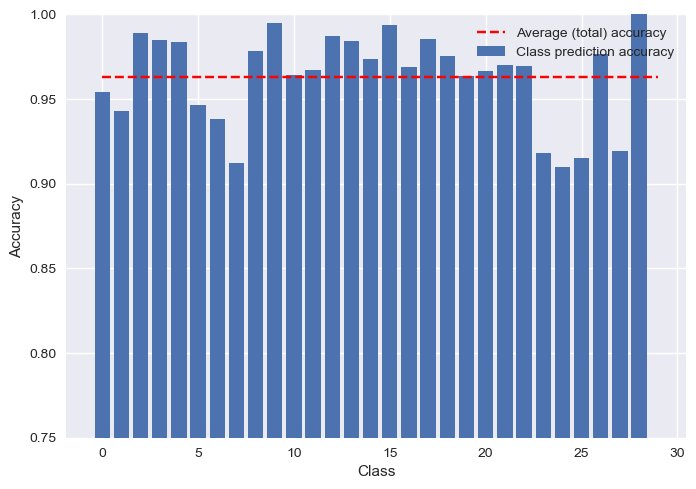

In [194]:
plt.style.use("seaborn");
plt.ylim([0.75, 1])
plt.bar(range(num_classes), class_accuracy, label="Class prediction accuracy")
plt.hlines(accuracy, 0, num_classes, colors="red", linestyles="--", label="Average (total) accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.legend()